# Exploratory Analysis

This notebook contains decisions in the exploratory analysis process of the Austin crime project.

## The Required Imports

Here we'll import all the modules required to run the code cells in this notebook.

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_crime_data
from prepare import split_data
from explore import *

## Acquire and Prepare Data

Here we'll acquire and prepare the data using the wrangle module.

In [2]:
df = wrangle_crime_data()
df.shape

Using cached csv


(349530, 17)

## Split the Data

Now we will need to split the data before we begin exploring because we will now begin exploring the relationship between the target variable and other features in the data.

In [3]:
train, validate, test = split_data(df)
train.shape, validate.shape, test.shape

((195736, 17), (83888, 17), (69906, 17))

From here on we'll only use the train variable.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195736 entries, 256829 to 125659
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   crime_type        195736 non-null  object        
 1   family_violence   195736 non-null  object        
 2   occurrence_time   195736 non-null  datetime64[ns]
 3   occurrence_date   195736 non-null  datetime64[ns]
 4   report_time       195736 non-null  datetime64[ns]
 5   report_date       195736 non-null  datetime64[ns]
 6   location_type     195736 non-null  object        
 7   address           195736 non-null  object        
 8   zip_code          195736 non-null  float64       
 9   council_district  195736 non-null  float64       
 10  sector            195736 non-null  object        
 11  district          195736 non-null  object        
 12  latitude          195736 non-null  float64       
 13  longitude         195736 non-null  float64       
 14 

## Does the difference between time of incident and report time relate to a crime being solved/closed?

In this notebook we're going to explore the relationship between the clearance status of a case and the difference in time between when the incident occurred and when the incident was reported.

### Engineer Time Difference Feature

In order to answer this question we will need to create a feature which contains the difference in time between when a crime occurred and when it was reported.

In [7]:
train['time_to_report'] = train.report_time - train.occurrence_time
train.time_to_report.head()

256829    2 days 19:26:00
123369    0 days 21:19:00
319089    1 days 03:10:00
37631    16 days 22:47:00
221040    0 days 16:17:00
Name: time_to_report, dtype: timedelta64[ns]

Now we have the difference between the time when a crime was reported and when it occurred, but we may need to bin this column to help with exploration. There are a lot of unique values in here so in order to gain meaningful insights from this feature we will need to create bins.

### Binning the Time to Report Column

We'll need to create bins for our data to make exploration easier. We'll create 6 distinct bins: No difference in occurrence and report time, 1 minute - 1 hour, 1 hour - 6 hours, 6 hours - 1 day, 1 day - 1 week, and greater than 1 week.

In [86]:
train['time_to_report_bins'] = pd.cut(
    train.time_to_report,
    [
        pd.Timedelta('-1d'),
        pd.Timedelta('59s'),
        pd.Timedelta('59m'),
        pd.Timedelta('6h'),
        pd.Timedelta('1d'),
        pd.Timedelta('7d'),
        pd.Timedelta('10y')
    ],
    labels = [
        'No difference',
        '1 minute - 1 hour',
        '1 hour - 6 hours',
        '6 hours - 1 day',
        '1 day - 1 week',
        'Greater than 1 week'
    ]
)

In [87]:
train.time_to_report_bins.value_counts()

No difference          81774
6 hours - 1 day        30133
1 day - 1 week         28036
1 hour - 6 hours       24249
Greater than 1 week    16245
1 minute - 1 hour      15327
Name: time_to_report_bins, dtype: int64

### Visualize the Results

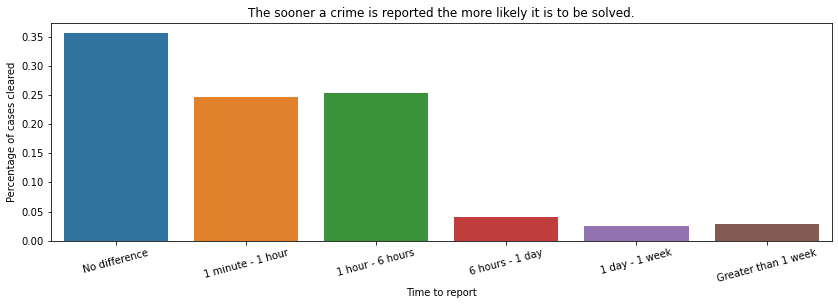

In [89]:
plt.figure(figsize = (14, 4))

sns.barplot(
    data = train,
    x = 'time_to_report_bins',
    y = 'cleared',
    ci = None
)

plt.xticks(rotation = 15)

plt.xlabel('Time to report')
plt.ylabel('Percentage of cases cleared')

plt.title('The sooner a crime is reported the more likely it is to be solved.');

#### Takeaways

From the visualization we can determine that the clearance status of a case does depend on the amount time between when the crime occurred and when it was reported. We can verify the significance of this finding with a statistical test.

### Stats Test

We'll be testing the following hypothesis:

$H_0$: The clearance status of a case is independent of the difference in time between when a crime occurred and when it was reported.
<br>
$H_a$: The clearance status of a case is dependent on the difference in time between when a crime occurred and when it was reported.

In [91]:
chi2(train.time_to_report_bins, train.cleared)

The chi2 value between the two variables is 25046.03220200103 and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


The results are that we reject the null hypothesis meaning that the clearance status of a case is dependent on the time to report the crime.